# **Homework 2: Determinants of Capital Structure**

# Applied Corporate Finance – FINA60223A.H2026

# Prof. Jakub Hajda

# Team: Nguyen-Bao Michael Hoang, Philippe Thériault et Nguyen Quoc-Long Tran

# **Importation of packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from collections import defaultdict

# **Data Importation** 

In [ ]:
# Load the dataset
data = pd.read_csv("Data preparation.csv")

# Display the first rows
data.head()

# Dataset dimensions
data.shape
print(f"Total number of observations: {data.shape[0]}")

# List of columns
data.columns

Total number of observations: 619527


Index(['costat', 'curcd', 'datafmt', 'indfmt', 'consol', 'tic', 'datadate',
       'gvkey', 'sic', 'fyear', 'at', 'dlc', 'dltt', 'intan', 'ppent', 'pstkl',
       'txditc', 'dvc', 'oibdp', 'csho', 'prcc_f'],
      dtype='object')

#### There is 14 variable that we taked from compustat dated from january 1965 to february 2026.

# **1. Exploratory data analysis**

In [3]:
# Overview of the raw dataset
print(f"Dataset shape: {data.shape}")
print(f"\nColumn types:")
print(data.dtypes)
print(f"\nMissing values per column:")
print(data.isnull().sum())
print(f"\nBasic statistics:")
data.describe()

Dataset shape: (619527, 21)

Column types:
costat       object
curcd        object
datafmt      object
indfmt       object
consol       object
tic          object
datadate     object
gvkey         int64
sic           int64
fyear         int64
at          float64
dlc         float64
dltt        float64
intan       float64
ppent       float64
pstkl       float64
txditc      float64
dvc         float64
oibdp       float64
csho        float64
prcc_f      float64
dtype: object

Missing values per column:
costat           0
curcd            0
datafmt          0
indfmt           0
consol           0
tic            233
datadate         0
gvkey            0
sic              0
fyear            0
at          101164
dlc         108042
dltt        103649
intan       141292
ppent       111931
pstkl       147428
txditc      185378
dvc         106473
oibdp       157497
csho         79382
prcc_f      103595
dtype: int64

Basic statistics:


,gvkey,sic,fyear,at,dlc,dltt,intan,ppent,pstkl,txditc,dvc,oibdp,csho,prcc_f
count,619527.000000,619527.000000,619527.000000,5.183630e+05,511485.000000,5.158780e+05,478235.000000,507596.000000,472099.000000,434149.000000,513054.000000,462030.000000,5.401450e+05,515932.000000
mean,51214.061051,4979.170532,1999.782295,9.134132e+03,827.418131,1.598147e+03,512.053667,861.861055,36.702964,115.456924,60.221264,353.491556,1.427810e+02,30.101585
std,62707.558513,2042.095987,15.750636,9.208578e+04,11532.846160,3.392675e+04,4107.046079,5749.593105,1310.267912,946.552598,455.657758,2419.638818,3.543009e+04,671.257799
min,1000.000000,100.000000,1964.000000,0.000000e+00,-3753.453000,-2.300000e-02,-40.455000,0.000000,-0.421000,-285.769000,-10.000000,-76735.000000,0.000000e+00,0.000001
25%,8633.000000,3531.000000,1988.000000,2.115800e+01,0.080000,1.660000e-01,0.000000,2.101000,0.000000,0.000000,0.000000,-0.045000,3.016000e+00,3.900000
50%,20408.000000,5311.000000,2001.000000,1.603580e+02,2.315000,1.079850e+01,0.250000,15.954500,0.000000,0.000000,0.000000,7.389000,1.108100e+01,13.000000
75%,64994.000000,6722.000000,2013.000000,1.195489e+03,26.583000,1.699207e+02,24.549000,131.730500,0.000000,5.965000,5.070750,70.403000,4.120300e+01,26.750000
max,369350.000000,9998.000000,2025.000000,4.424900e+06,614237.411000,4.216909e+06,310197.000000,328806.000000,526300.000000,92344.000000,100117.000000,156528.000000,2.597496e+07,141600.000000


## 1.1. Duplicates, U.S. firms, and sample size

In [4]:
# Check for duplicates
duplicates = data.duplicated(subset=['gvkey', 'fyear']).sum()
print(f"Number of duplicate (gvkey, fyear) entries: {duplicates}")

# Remove duplicates if any
data = data.drop_duplicates(subset=['gvkey', 'fyear'], keep='first')
print(f"Observations after removing duplicates: {len(data):,}")

# Filter to U.S. firms only (curcd == 'USD')
print(f"\nBefore U.S. filter: {len(data):,} observations")
data = data[data['curcd'] == 'USD'].copy()
print(f"After U.S. filter (curcd = USD): {len(data):,} observations")
print(f"Number of unique U.S. firms: {data['gvkey'].nunique():,}")
print(f"Year range: {data['fyear'].min():.0f} - {data['fyear'].max():.0f}")

Number of duplicate (gvkey, fyear) entries: 47479
Observations after removing duplicates: 572,048

Before U.S. filter: 572,048 observations
After U.S. filter (curcd = USD): 503,194 observations
Number of unique U.S. firms: 40,630
Year range: 1964 - 2025


### **Interpretation:**
We filter the dataset to keep only U.S. firms (currency code = USD) and remove any duplicate firm-year observations to ensure one observation per firm per year.

## 1.2. Data Cleaning and Filters

In [5]:
# Remove financial firms (SIC 6000-6999) and utilities (SIC 4900-4999)
print(f"Before industry filter: {len(data):,} observations")
data = data[~((data['sic'] >= 6000) & (data['sic'] <= 6999))].copy()
data = data[~((data['sic'] >= 4900) & (data['sic'] <= 4999))].copy()
print(f"After removing financials and utilities: {len(data):,} observations")

# Remove observations with missing key variables
data = data.dropna(subset=['at', 'dlc', 'dltt', 'fyear', 'gvkey', 'sic'])
print(f"After removing missing key variables: {len(data):,} observations")

# Remove observations with non-positive total assets
data = data[data['at'] > 0].copy()
print(f"After removing non-positive assets: {len(data):,} observations")

# --- VARIABLE CONSTRUCTION ---

# Total Debt = short-term debt (dlc) + long-term debt (dltt)
data['total_debt'] = data['dlc'].fillna(0) + data['dltt'].fillna(0)

# Book Leverage = total debt / total assets
data['book_leverage'] = data['total_debt'] / data['at']

# Market Equity = stock price * shares outstanding
data['market_equity'] = data['prcc_f'] * data['csho']

# Market Leverage = total debt / (total debt + market equity)
data['market_leverage'] = data['total_debt'] / (data['total_debt'] + data['market_equity'])
data.loc[data['market_equity'].isna() | (data['market_equity'] <= 0), 'market_leverage'] = np.nan

# Firm Size = log(book assets)
data['log_assets'] = np.log(data['at'])

# Profitability = operating income before depreciation / book assets
data['profitability'] = data['oibdp'] / data['at']

# Tangibility = net PPE / book assets
data['tangibility'] = data['ppent'] / data['at']

# Market-to-Book = (market equity + total debt + preferred stock liquidating value - deferred taxes) / book assets
data['market_to_book'] = (data['market_equity'] + data['total_debt'] + 
                          data['pstkl'].fillna(0) - data['txditc'].fillna(0)) / data['at']

# Dividend Payer dummy (1 if firm pays cash dividends, 0 otherwise)
data['dividend_payer'] = (data['dvc'].fillna(0) > 0).astype(int)

# Intangible assets ratio
data['intangible_assets'] = data['intan'].fillna(0) / data['at']

# Industry code (4-digit SIC)
data['sic4'] = data['sic'].astype(int)

# Industry Median Book Leverage (by industry-year)
data['ind_med_book_lev'] = data.groupby(['fyear', 'sic4'])['book_leverage'].transform('median')

# --- TRIMMING OUTLIERS (1st and 99th percentile) ---
# Note: the paper trims (removes) rather than winsorizes

def trim_variable(df, var_name, lower=0.01, upper=0.99):
    q_low = df[var_name].quantile(lower)
    q_high = df[var_name].quantile(upper)
    df = df[(df[var_name] >= q_low) & (df[var_name] <= q_high)]
    return df

for var in ['book_leverage', 'market_leverage', 'profitability', 'tangibility', 'market_to_book', 'log_assets']:
    if var in data.columns:
        data = trim_variable(data, var)

# Keep leverage between 0 and 1
data = data[(data['book_leverage'] >= 0) & (data['book_leverage'] <= 1)]
data = data[((data['market_leverage'] >= 0) & (data['market_leverage'] <= 1)) | data['market_leverage'].isna()]

print(f"\nAfter trimming: {len(data):,} observations")
print(f"Number of unique firms: {data['gvkey'].nunique():,}")
print(f"Year range: {data['fyear'].min():.0f} - {data['fyear'].max():.0f}")

Before industry filter: 503,194 observations
After removing financials and utilities: 345,562 observations
After removing missing key variables: 323,801 observations
After removing non-positive assets: 322,714 observations

After trimming: 241,668 observations
Number of unique firms: 22,403
Year range: 1964 - 2025


## 1.3. Cash Flow Volatility

In [6]:
# Cash Flow Volatility
# Note: The homework requires quarterly data (oibdptq, atq) to compute cash flow volatility
# as the standard deviation of quarterly profitability over 8 quarters (current + preceding year).
# Since the quarterly Compustat data is not included in the provided CSV,
# we cannot compute cf_volatility as specified.
# 
# If quarterly data were available, the procedure would be:
# 1. Calculate quarterly profitability = oibdptq / atq
# 2. For each firm-year, compute std dev of profitability over 8 quarters (current + preceding fiscal year)
# 3. Replace with NaN if fewer than 4 quarterly observations available
# 4. Merge to annual data and lag by one year

print("Cash flow volatility (cf_volatility) requires quarterly Compustat data (oibdptq, atq).")
print("This variable is not included in the current dataset.")
print("The regressions below will proceed without cf_volatility.")

Cash flow volatility (cf_volatility) requires quarterly Compustat data (oibdptq, atq).
This variable is not included in the current dataset.
The regressions below will proceed without cf_volatility.


### **Interpretation:**
Cash flow volatility measures the uncertainty in a firm's operating cash flows. According to the paper, it is computed as the standard deviation of quarterly profitability (operating income / assets) over an 8-quarter rolling window. Higher cash flow volatility is expected to be associated with lower leverage, as firms with more volatile cash flows face higher expected costs of financial distress. Since the quarterly data is not available in the provided dataset, this variable is omitted from the regressions.

## 1.4. Summary Statistics: Table I

### *1.4.1. All Firms*

In [7]:
# Table I Replication: Summary Statistics - All Firms

summary_vars = ['book_leverage', 'market_leverage', 'log_assets', 'market_to_book',
                'profitability', 'tangibility', 'dividend_payer', 'ind_med_book_lev']

stats = data[summary_vars].describe().T[['mean', '50%', 'std', 'min', 'max', 'count']]
stats.columns = ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'N']

var_display = {
    'book_leverage': 'Book Leverage',
    'market_leverage': 'Market Leverage',
    'log_assets': 'Log(Assets)',
    'market_to_book': 'Market-to-Book',
    'profitability': 'Profitability',
    'tangibility': 'Tangibility',
    'dividend_payer': 'Dividend Payer',
    'ind_med_book_lev': 'Industry Median Leverage'
}
stats.index = [var_display.get(v, v) for v in stats.index]

print("TABLE I - SUMMARY STATISTICS: ALL FIRMS")
print(f"Sample period: {data['fyear'].min():.0f} - {data['fyear'].max():.0f}")
print(f"Number of observations: {len(data):,}")
print()
print(stats.round(4).to_string())

TABLE I - SUMMARY STATISTICS: ALL FIRMS
Sample period: 1964 - 2025
Number of observations: 241,668

                            Mean  Median  Std Dev     Min      Max         N
Book Leverage             0.2360  0.2075   0.2058  0.0000   1.0000  241668.0
Market Leverage           0.2415  0.1707   0.2400  0.0000   0.9354  241668.0
Log(Assets)               4.8920  4.6870   2.3034 -0.0747  10.9134  241668.0
Market-to-Book            1.7341  1.1155   1.8822  0.2451  18.3373  241668.0
Profitability             0.0264  0.1050   0.3072 -3.4443   0.4057  241668.0
Tangibility               0.2793  0.2220   0.2262  0.0000   0.9107  241668.0
Dividend Payer            0.3598  0.0000   0.4799  0.0000   1.0000  241668.0
Industry Median Leverage  0.2198  0.2160   0.1577  0.0000  28.1068  241668.0


### *1.4.2. Subsample: 1965–2003*

In [8]:
# Table I: Summary Statistics - Subsample 1965-2003

data_sub1 = data[(data['fyear'] >= 1965) & (data['fyear'] <= 2003)]

stats_sub1 = data_sub1[summary_vars].describe().T[['mean', '50%', 'std', 'min', 'max', 'count']]
stats_sub1.columns = ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'N']
stats_sub1.index = [var_display.get(v, v) for v in stats_sub1.index]

print("TABLE I - SUMMARY STATISTICS: 1965-2003")
print(f"Number of observations: {len(data_sub1):,}")
print()
print(stats_sub1.round(4).to_string())

TABLE I - SUMMARY STATISTICS: 1965-2003
Number of observations: 155,453

                            Mean  Median  Std Dev     Min      Max         N
Book Leverage             0.2441  0.2219   0.1990  0.0000   1.0000  155453.0
Market Leverage           0.2665  0.2047   0.2459  0.0000   0.9354  155453.0
Log(Assets)               4.3377  4.1458   2.0750 -0.0747  10.9127  155453.0
Market-to-Book            1.5926  1.0243   1.7618  0.2451  18.3278  155453.0
Profitability             0.0639  0.1189   0.2514 -3.4443   0.4057  155453.0
Tangibility               0.3069  0.2608   0.2171  0.0000   0.9107  155453.0
Dividend Payer            0.3977  0.0000   0.4894  0.0000   1.0000  155453.0
Industry Median Leverage  0.2316  0.2312   0.1230  0.0000   3.7230  155453.0


### *1.4.3. Subsample: 2004–Most Recent*

In [9]:
# Table I: Summary Statistics - Subsample 2004-Most Recent

data_sub2 = data[data['fyear'] >= 2004]

stats_sub2 = data_sub2[summary_vars].describe().T[['mean', '50%', 'std', 'min', 'max', 'count']]
stats_sub2.columns = ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'N']
stats_sub2.index = [var_display.get(v, v) for v in stats_sub2.index]

print("TABLE I - SUMMARY STATISTICS: 2004-MOST RECENT")
print(f"Number of observations: {len(data_sub2):,}")
print()
print(stats_sub2.round(4).to_string())

TABLE I - SUMMARY STATISTICS: 2004-MOST RECENT
Number of observations: 86,142

                            Mean  Median  Std Dev     Min      Max        N
Book Leverage             0.2215  0.1762   0.2167  0.0000   1.0000  86142.0
Market Leverage           0.1965  0.1183   0.2219  0.0000   0.9352  86142.0
Log(Assets)               5.8925  5.9396   2.3574 -0.0736  10.9134  86142.0
Market-to-Book            1.9896  1.3067   2.0582  0.2451  18.3373  86142.0
Profitability            -0.0416  0.0792   0.3789 -3.4289   0.4057  86142.0
Tangibility               0.2295  0.1394   0.2338  0.0000   0.9106  86142.0
Dividend Payer            0.2910  0.0000   0.4542  0.0000   1.0000  86142.0
Industry Median Leverage  0.1986  0.1764   0.2043  0.0000  28.1068  86142.0


### **Interpretation:**
The summary statistics allow us to compare the characteristics of firms across the two subperiods. Key differences may emerge in leverage levels, market-to-book ratios, and the proportion of dividend payers between the original sample period (1965–2003) and the more recent period (2004–present), reflecting changes in corporate financing behavior, market conditions, and the composition of publicly traded firms over time.

## 1.5. Persistence and Spurious Correlation (Figure 1) and Lag Structure

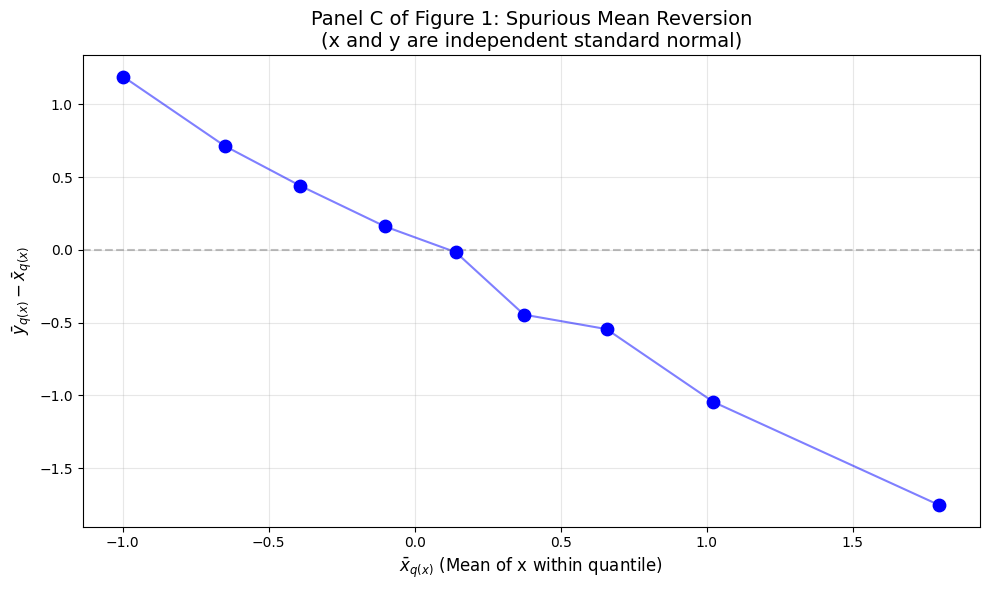


Explanation:
Even though x and y are completely independent random variables,
sorting by x and computing y_bar - x_bar within quantiles produces
a strong downward-sloping pattern. This is because extreme quantiles
of x mechanically have extreme x_bar values, while y_bar stays near 0.
This demonstrates that the mean reversion pattern in Figure 1 of the
paper could be spurious - arising from sorting rather than true convergence.

APPLYING LAG STRUCTURE
Before dropping missing lagged values: 241,668 observations
After dropping missing lagged values: 219,265 observations
Number of unique firms: 20,416
Year range: 1965 - 2025


In [10]:
# --- Panel C of Figure 1: Spurious Correlation Demonstration ---

# Simulate two sets of random numbers from the standard normal distribution
np.random.seed(42)
n = 1000
x = np.random.standard_normal(n)
y = np.random.standard_normal(n)

# Create 10 quantiles based on x (11 boundaries define 10 intervals)
quantiles = np.quantile(x, np.linspace(0, 1, 11))

# Calculate mean of x and y within 9 quantile ranges (q1-q2 through q9-q10, as per homework)
x_means = []
y_means = []
for i in range(1, 10):  # quantile ranges 1-2 through 9-10
    mask = (x >= quantiles[i]) & (x < quantiles[i+1]) if i < 9 else (x >= quantiles[i]) & (x <= quantiles[i+1])
    x_means.append(x[mask].mean())
    y_means.append(y[mask].mean())

x_means = np.array(x_means)
y_means = np.array(y_means)

# Plot y_bar_q(x) - x_bar_q(x) vs x_bar_q(x)
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x_means, y_means - x_means, color='blue', s=80, zorder=5)
ax.plot(x_means, y_means - x_means, 'b-', alpha=0.5)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('$\\bar{x}_{q(x)}$ (Mean of x within quantile)', fontsize=12)
ax.set_ylabel('$\\bar{y}_{q(x)} - \\bar{x}_{q(x)}$', fontsize=12)
ax.set_title('Panel C of Figure 1: Spurious Mean Reversion\n(x and y are independent standard normal)', fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nExplanation:")
print("Even though x and y are completely independent random variables,")
print("sorting by x and computing y_bar - x_bar within quantiles produces")
print("a strong downward-sloping pattern. This is because extreme quantiles")
print("of x mechanically have extreme x_bar values, while y_bar stays near 0.")
print("This demonstrates that the mean reversion pattern in Figure 1 of the")
print("paper could be spurious - arising from sorting rather than true convergence.")

# --- LAG STRUCTURE ---
# Lag explanatory variables by one period (as required by the homework)

print("\n" + "=" * 60)
print("APPLYING LAG STRUCTURE")
print("=" * 60)

data = data.sort_values(['gvkey', 'fyear'])

lag_vars = ['log_assets', 'market_to_book', 'profitability', 'tangibility', 
            'dividend_payer', 'ind_med_book_lev', 'intangible_assets']

for var in lag_vars:
    data[f'{var}_lag'] = data.groupby('gvkey')[var].shift(1)

# Drop all rows with missing data (including those with missing lagged values)
print(f"Before dropping missing lagged values: {len(data):,} observations")
data = data.dropna(subset=[f'{var}_lag' for var in lag_vars])
print(f"After dropping missing lagged values: {len(data):,} observations")
print(f"Number of unique firms: {data['gvkey'].nunique():,}")
print(f"Year range: {data['fyear'].min():.0f} - {data['fyear'].max():.0f}")

### **Interpretation:**
The simulation demonstrates that sorting by initial values of a variable and then plotting the difference between a second variable and the first within quantiles can produce a mechanical mean-reversion pattern, even when the two variables are completely independent. This is because the extreme quantiles of x have extreme means by construction, while the mean of the independent variable y stays near zero. This suggests that the cross-sectional sorting results in Figure 1 of the paper (showing that high-leverage firms decrease their leverage and vice versa) might partly reflect this statistical artifact rather than true economic convergence toward a target capital structure.

# **2. Leverage Models**

## 2.1. Replication of Table II – Panel A

In [11]:
# --- TABLE II PANEL A: Effect of Initial Leverage on Future Leverage ---

# Initial leverage: for each firm, leverage in the first year they appear in the sample
first_year = data.groupby('gvkey')['fyear'].transform('min')
data['initial_leverage'] = np.where(data['fyear'] == first_year, data['book_leverage'], np.nan)
data['initial_leverage'] = data.groupby('gvkey')['initial_leverage'].transform('first')

# Create industry-year interaction variable
data['ind_year'] = data['sic4'].astype(str) + '_' + data['fyear'].astype(str)

# Set panel identifiers
data['firm_id'] = pd.Categorical(data['gvkey']).codes
data['year_id'] = pd.Categorical(data['fyear']).codes

print(f"Final sample size: {len(data):,} observations")
print(f"Number of unique firms: {data['gvkey'].nunique():,}")
print(f"Year range: {data['fyear'].min():.0f} - {data['fyear'].max():.0f}")
print()

# Variables for Table II Panel A (including initial leverage)
X_vars = ['log_assets_lag', 'market_to_book_lag', 'profitability_lag', 
          'tangibility_lag', 'ind_med_book_lev_lag', 'dividend_payer_lag', 'initial_leverage']

# Display name mapping
var_names_display = {
    'log_assets_lag': 'Log(Assets)',
    'market_to_book_lag': 'Market-to-Book',
    'profitability_lag': 'Profitability',
    'tangibility_lag': 'Tangibility',
    'ind_med_book_lev_lag': 'Industry Median Leverage',
    'dividend_payer_lag': 'Dividend Payer',
    'initial_leverage': 'Initial Leverage'
}

# Store results
table_2_results = {}

for lev_type in ['book_leverage', 'market_leverage']:
    # Prepare regression data
    reg_data = data[['gvkey', 'fyear', lev_type] + X_vars].dropna()
    
    # Calculate standard deviations for standardization
    std_dict = {}
    for var in X_vars + [lev_type]:
        std_dict[var] = reg_data[var].std()
    
    # Standardize variables (coefficients scaled by standard deviation)
    reg_data_std = reg_data.copy()
    for var in X_vars + [lev_type]:
        reg_data_std[var] = reg_data[var] / std_dict[var]
    
    # Run OLS with standardized variables
    X = sm.add_constant(reg_data_std[X_vars])
    y = reg_data_std[lev_type]
    
    model = sm.OLS(y, X).fit()
    
    # Store results
    table_2_results[lev_type] = {
        'params': model.params[1:],  # Exclude constant
        'std_err': model.bse[1:],
        't_stat': model.tvalues[1:],
        'r_squared': model.rsquared,
        'n_obs': model.nobs
    }

# Print Table II Panel A
print("TABLE II - PANEL A: Effect of Initial Leverage on Future Leverage")
print("(Coefficients scaled by standard deviation)")
print()

print(f"{'Variable':<30} {'Book Leverage':>20} {'Market Leverage':>20}")
print("-" * 70)

for var in X_vars:
    book_coef = table_2_results['book_leverage']['params'][var]
    book_tstat = table_2_results['book_leverage']['t_stat'][var]
    mkt_coef = table_2_results['market_leverage']['params'][var]
    mkt_tstat = table_2_results['market_leverage']['t_stat'][var]
    
    display_name = var_names_display.get(var, var)
    print(f"{display_name:<30} {book_coef:>10.4f} ({book_tstat:>6.2f})   {mkt_coef:>10.4f} ({mkt_tstat:>6.2f})")

print("-" * 70)
print(f"{'R-squared':<30} {table_2_results['book_leverage']['r_squared']:>20.4f} {table_2_results['market_leverage']['r_squared']:>20.4f}")
print(f"{'N observations':<30} {int(table_2_results['book_leverage']['n_obs']):>20,} {int(table_2_results['market_leverage']['n_obs']):>20,}")
print()
print("Note: t-statistics in parentheses")

Final sample size: 219,265 observations
Number of unique firms: 20,416
Year range: 1965 - 2025

TABLE II - PANEL A: Effect of Initial Leverage on Future Leverage
(Coefficients scaled by standard deviation)

Variable                              Book Leverage      Market Leverage
----------------------------------------------------------------------
Log(Assets)                        0.1220 ( 63.65)       0.0572 ( 29.92)
Market-to-Book                    -0.0481 (-25.83)      -0.2733 (-147.33)
Profitability                     -0.0715 (-36.66)      -0.0539 (-27.73)
Tangibility                        0.1203 ( 63.54)       0.1117 ( 59.17)
Industry Median Leverage           0.1790 ( 94.35)       0.1741 ( 92.07)
Dividend Payer                    -0.0928 (-47.90)      -0.0731 (-37.84)
Initial Leverage                   0.4341 (234.55)       0.3467 (187.91)
----------------------------------------------------------------------
R-squared                                    0.3451               

## 2.2. Baseline Leverage Regressions
### $$\text{Leverage}_{it} = \alpha + \beta X_{i,t-1} + \varepsilon_{it}$$

### *2.2.1. (a) Pooled OLS*

In [ ]:
# Variables for regression (
X_vars_baseline = ['log_assets_lag', 'market_to_book_lag', 'profitability_lag', 
                   'tangibility_lag', 'ind_med_book_lev_lag', 'dividend_payer_lag']

# Store all regression results for comparison
all_results = defaultdict(dict)

for lev_type in ['book_leverage', 'market_leverage']:
    # Prepare regression data
    reg_data = data[['gvkey', 'fyear', 'firm_id', lev_type] + X_vars_baseline].dropna()
    
    # Pooled OLS
    X = sm.add_constant(reg_data[X_vars_baseline])
    y = reg_data[lev_type]
    
    model_pooled = sm.OLS(y, X).fit()
    
    # Store results
    all_results[lev_type]['pooled_ols'] = {
        'model': model_pooled,
        'params': model_pooled.params,
        'std_err': model_pooled.bse,
        't_stat': model_pooled.tvalues,
        'r_squared': model_pooled.rsquared,
        'r_squared_adj': model_pooled.rsquared_adj,
        'n_obs': model_pooled.nobs
    }

# Display results for Pooled OLS
for lev_type in ['book_leverage', 'market_leverage']:
    lev_name = 'Book Leverage' if lev_type == 'book_leverage' else 'Market Leverage'
    results = all_results[lev_type]['pooled_ols']
    
    print(f"\nDependent Variable: {lev_name}")
    print("-" * 60)
    print(f"{'Variable':<30} {'Coefficient':>15} {'t-stat':>12}")
    print("-" * 60)
    
    for var in ['const'] + X_vars_baseline:
        display_name = var_names_display.get(var, var) if var != 'const' else 'Constant'
        coef = results['params'][var]
        tstat = results['t_stat'][var]
        print(f"{display_name:<30} {coef:>15.6f} {tstat:>12.2f}")
    
    print("-" * 60)
    print(f"R-squared: {results['r_squared']:.4f}")
    print(f"Adj. R-squared: {results['r_squared_adj']:.4f}")
    print(f"N observations: {int(results['n_obs']):,}")
    print()


Dependent Variable: Book Leverage
------------------------------------------------------------
Variable                           Coefficient       t-stat
------------------------------------------------------------
Constant                              0.085746        68.85
Log(Assets)                           0.012364        64.51
Market-to-Book                       -0.008988       -39.46
Profitability                        -0.046636       -29.35
Tangibility                           0.174167        91.28
Industry Median Leverage              0.366926       137.62
Dividend Payer                       -0.051222       -56.07
------------------------------------------------------------
R-squared: 0.1808
Adj. R-squared: 0.1807
N observations: 219,265


Dependent Variable: Market Leverage
------------------------------------------------------------
Variable                           Coefficient       t-stat
------------------------------------------------------------
Constant         

### *2.2.2. (b) Year Fixed Effects*

In [ ]:
for lev_type in ['book_leverage', 'market_leverage']:
    # Prepare regression data
    reg_data = data[['gvkey', 'fyear', 'firm_id', lev_type] + X_vars_baseline].dropna().copy()
    
    # Create year dummies with dtype=int to ensures consistent types
    
    #  dtype=int ensures consistent types.
    year_dummies = pd.get_dummies(reg_data['fyear'].astype(int), prefix='year', drop_first=True, dtype=int)
    
    # Combine X variables with year dummies - reset indices to ensure alignment
    X = pd.concat([reg_data[X_vars_baseline].reset_index(drop=True),  year_dummies.reset_index(drop=True)], axis=1)
    X = sm.add_constant(X)
    y = reg_data[lev_type].reset_index(drop=True)
    
    model_year_fe = sm.OLS(y, X).fit()
    
    # Store results
    all_results[lev_type]['year_fe'] = {
        'model': model_year_fe,
        'params': model_year_fe.params,
        'std_err': model_year_fe.bse,
        't_stat': model_year_fe.tvalues,
        'r_squared': model_year_fe.rsquared,
        'r_squared_adj': model_year_fe.rsquared_adj,
        'n_obs': model_year_fe.nobs
    }

# Display Year FE results
for lev_type in ['book_leverage', 'market_leverage']:
    lev_name = 'Book Leverage' if lev_type == 'book_leverage' else 'Market Leverage'
    results = all_results[lev_type]['year_fe']
    
    print(f"\nDependent Variable: {lev_name}")
    print("-" * 60)
    print(f"{'Variable':<30} {'Coefficient':>15} {'t-stat':>12}")
    print("-" * 60)
    
    for var in X_vars_baseline:
        display_name = var_names_display.get(var, var)
        coef = results['params'][var]
        tstat = results['t_stat'][var]
        print(f"{display_name:<30} {coef:>15.6f} {tstat:>12.2f}")
    
    print("-" * 60)
    print(f"Year Fixed Effects: Yes")
    print(f"R-squared: {results['r_squared']:.4f}")
    print(f"Adj. R-squared: {results['r_squared_adj']:.4f}")
    print(f"N observations: {int(results['n_obs']):,}")
    print()


Dependent Variable: Book Leverage
------------------------------------------------------------
Variable                           Coefficient       t-stat
------------------------------------------------------------
Log(Assets)                           0.018256        79.43
Market-to-Book                       -0.008389       -36.51
Profitability                        -0.065432       -39.70
Tangibility                           0.161531        84.04
Industry Median Leverage              0.348645       130.02
Dividend Payer                       -0.069454       -70.72
------------------------------------------------------------
Year Fixed Effects: Yes
R-squared: 0.1956
Adj. R-squared: 0.1953
N observations: 219,265


Dependent Variable: Market Leverage
------------------------------------------------------------
Variable                           Coefficient       t-stat
------------------------------------------------------------
Log(Assets)                           0.020434       

### *2.2.3. (c) Firm and Year Fixed Effects*

In [ ]:
for lev_type in ['book_leverage', 'market_leverage']:
    
    # Prepare panel data
    reg_data = data[['gvkey', 'fyear', lev_type] + X_vars_baseline].dropna().copy()
    
    #  multi-index for panel data
    reg_data = reg_data.set_index(['gvkey', 'fyear'])
    
    # Prepare dependent and independent variables
    y = reg_data[lev_type]
    X = reg_data[X_vars_baseline]
    
    # Estimate panel model with firm and time effects (two-way fixed effects)
    try:
        model_firm_year_fe = PanelOLS(y, X, entity_effects=True, time_effects=True).fit()
        
        # Store results
        all_results[lev_type]['firm_year_fe'] = {
            'model': model_firm_year_fe,
            'params': model_firm_year_fe.params,
            'std_err': model_firm_year_fe.std_errors,
            't_stat': model_firm_year_fe.tstats,
            'r_squared': model_firm_year_fe.rsquared,
            'r_squared_within': model_firm_year_fe.rsquared_within,
            'n_obs': model_firm_year_fe.nobs
        }
    except Exception as e:
        print(f"Error fitting firm+year FE for {lev_type}: {e}")
        continue

# Display Firm + Year FE results
for lev_type in ['book_leverage', 'market_leverage']:
    if 'firm_year_fe' not in all_results[lev_type]:
        continue
    
    lev_name = 'Book Leverage' if lev_type == 'book_leverage' else 'Market Leverage'
    results = all_results[lev_type]['firm_year_fe']
    
    print(f"\nDependent Variable: {lev_name}")
    print("-" * 60)
    print(f"{'Variable':<30} {'Coefficient':>15} {'t-stat':>12}")
    print("-" * 60)
    
    for var in X_vars_baseline:
        display_name = var_names_display.get(var, var)
        coef = results['params'][var]
        tstat = results['t_stat'][var]
        print(f"{display_name:<30} {coef:>15.6f} {tstat:>12.2f}")
    
    print("-" * 60)
    print(f"Firm Fixed Effects: Yes")
    print(f"Year Fixed Effects: Yes")
    print(f"R-squared (within): {results['r_squared_within']:.4f}")
    print(f"R-squared (overall): {results['r_squared']:.4f}")
    print(f"N observations: {int(results['n_obs']):,}")
    print()


Dependent Variable: Book Leverage
------------------------------------------------------------
Variable                           Coefficient       t-stat
------------------------------------------------------------
Log(Assets)                           0.027837        59.51
Market-to-Book                       -0.003946       -17.72
Profitability                        -0.080085       -45.12
Tangibility                           0.176817        55.80
Industry Median Leverage              0.121568        43.26
Dividend Payer                       -0.031710       -28.49
------------------------------------------------------------
Firm Fixed Effects: Yes
Year Fixed Effects: Yes
R-squared (within): 0.0592
R-squared (overall): 0.0557
N observations: 219,265


Dependent Variable: Market Leverage
------------------------------------------------------------
Variable                           Coefficient       t-stat
------------------------------------------------------------
Log(Assets)    

### *2.2.4. (d) Firm and Industry × Year Fixed Effects*

In [ ]:
# Helper function to safely get parameter values
def get_param_value(params, var_name):
    
    if params is None:
        return np.nan
    if isinstance(params, dict):
        return params.get(var_name, np.nan)
    if hasattr(params, 'get'):
        return params.get(var_name, np.nan)
    try:
        return params[var_name]
    except (KeyError, IndexError, TypeError):
        return np.nan

for lev_type in ['book_leverage', 'market_leverage']:
    # Prepare panel data - keep ind_year before setting index
    reg_data = data[['gvkey', 'fyear', 'ind_year', lev_type] + X_vars_baseline].dropna().copy()
    
    # Store ind_year before setting panel index
    ind_year_series = reg_data['ind_year'].copy()
    
    # Set multi-index for panel data
    reg_data = reg_data.set_index(['gvkey', 'fyear'])
    
    # Prepare dependent and independent variables
    y = reg_data[lev_type]
    X = reg_data[X_vars_baseline]
    
    # Align ind_year with panel index
    ind_year_aligned = pd.Series(ind_year_series.values, index=reg_data.index)
    
        # Firm FE with Industry×Year effects as other effects
    model_firm_indyear_fe = PanelOLS(y, X, entity_effects=True, time_effects=False, other_effects=ind_year_aligned).fit(low_memory=True, use_lsmr=True)
    
    all_results[lev_type]['firm_indyear_fe'] = {
        'model': model_firm_indyear_fe,
        'params': model_firm_indyear_fe.params,
        'std_err': model_firm_indyear_fe.std_errors,
        't_stat': model_firm_indyear_fe.tstats,
        'r_squared': model_firm_indyear_fe.rsquared,
        'r_squared_within': model_firm_indyear_fe.rsquared_within,
        'n_obs': model_firm_indyear_fe.nobs
    }

# Display Firm + Industry×Year FE results
for lev_type in ['book_leverage', 'market_leverage']:
    if 'firm_indyear_fe' not in all_results[lev_type] or all_results[lev_type]['firm_indyear_fe'] is None:
        continue
    
    lev_name = 'Book Leverage' if lev_type == 'book_leverage' else 'Market Leverage'
    results = all_results[lev_type]['firm_indyear_fe']
    
    print(f"\nDependent Variable: {lev_name}")
    print("-" * 60)
    print(f"{'Variable':<30} {'Coefficient':>15} {'t-stat':>12}")
    print("-" * 60)
    
    for var in X_vars_baseline:
        display_name = var_names_display.get(var, var)
        coef = get_param_value(results['params'], var)
        tstat = get_param_value(results['t_stat'], var)
        print(f"{display_name:<30} {coef:>15.6f} {tstat:>12.2f}")
    
    print("-" * 60)
    print(f"Firm Fixed Effects: Yes")
    print(f"Industry×Year Fixed Effects: Yes")
    print(f"R-squared (within): {results['r_squared_within']:.4f}")
    print(f"R-squared (overall): {results['r_squared']:.4f}")
    print(f"N observations: {int(results['n_obs']):,}")
    print()


Dependent Variable: Book Leverage
------------------------------------------------------------
Variable                           Coefficient       t-stat
------------------------------------------------------------
Log(Assets)                           0.028292        54.77
Market-to-Book                       -0.003382       -14.43
Profitability                        -0.076557       -41.70
Tangibility                           0.175711        51.17
Industry Median Leverage             -0.057325        -2.86
Dividend Payer                       -0.031421       -26.26
------------------------------------------------------------
Firm Fixed Effects: Yes
Industry×Year Fixed Effects: Yes
R-squared (within): 0.0344
R-squared (overall): 0.0424
N observations: 219,265


Dependent Variable: Market Leverage
------------------------------------------------------------
Variable                           Coefficient       t-stat
------------------------------------------------------------
Log(As

### **Interpretation:**

## 2.3. Economic Interpretation of the Results

In [ ]:
# 2.3 Economic Interpretation of the Results

# Calculate economic magnitude using summary statistics
summary_stats = data[X_vars_baseline + ['book_leverage', 'market_leverage']].describe()


print("SUMMARY STATISTICS FOR ECONOMIC INTERPRETATION")

print(summary_stats.T[['mean', 'std', '25%', '50%', '75%']].round(4))
print()

# Economic significance: What is the effect of a one-standard deviation change?

print("ECONOMIC SIGNIFICANCE: Effect of 1-SD Change in Each Variable")

for lev_type in ['book_leverage', 'market_leverage']:
    lev_name = 'Book Leverage' if lev_type == 'book_leverage' else 'Market Leverage'
    print(f"\n{lev_name}:")
    print("-" * 60)
    print(f"{'Variable':<30} {'SD':>10} {'Coef (Pooled)':>15} {'Effect':>12}")
    print("-" * 60)
    
    for var in X_vars_baseline:
        display_name = var_names_display.get(var, var)
        sd = summary_stats.loc[var, 'std'] if var in summary_stats.index else data[var].std()
        coef = get_param_value(all_results[lev_type]['pooled_ols']['params'], var)
        effect = sd * coef
        print(f"{display_name:<30} {sd:>10.4f} {coef:>15.6f} {effect:>12.4f}")
    
    mean_lev = data[lev_type].mean()
    print(f"\nMean {lev_name}: {mean_lev:.4f}")
    print()

SUMMARY STATISTICS FOR ECONOMIC INTERPRETATION
                        mean     std     25%     50%     75%
log_assets_lag        4.9274  2.2880  3.2101  4.7159  6.5204
market_to_book_lag    1.7306  1.8643  0.7476  1.1180  1.9197
profitability_lag     0.0408  0.2810  0.0231  0.1090  0.1700
tangibility_lag       0.2812  0.2243  0.0989  0.2255  0.4101
ind_med_book_lev_lag  0.2200  0.1583  0.1241  0.2166  0.2943
dividend_payer_lag    0.3759  0.4844  0.0000  0.0000  1.0000
book_leverage         0.2396  0.2047  0.0562  0.2135  0.3663
market_leverage       0.2498  0.2415  0.0343  0.1825  0.4041

ECONOMIC SIGNIFICANCE: Effect of 1-SD Change in Each Variable

Book Leverage:
------------------------------------------------------------
Variable                               SD   Coef (Pooled)       Effect
------------------------------------------------------------
Log(Assets)                        2.2880        0.012364       0.0283
Market-to-Book                     1.8643       -0.008988    

### **Interpretation:**

## 2.4. Firm vs. Industry Fixed Effects

In [ ]:
#  model with Industry FE (instead of Firm FE)
for lev_type in ['book_leverage', 'market_leverage']:
    # Prepare regression data
    reg_data = data[['gvkey', 'fyear', 'sic4', lev_type] + X_vars_baseline].dropna().copy()
    
    # Create industry dummies (convert to string for clarity, then to int dtype)
    industry_dummies = pd.get_dummies(reg_data['sic4'].astype(str), prefix='ind', drop_first=True, dtype=int)
    
    # Create year dummies 
    year_dummies = pd.get_dummies(reg_data['fyear'].astype(int), prefix='year', drop_first=True, dtype=int)
    
    # Combine X variables with industry and year dummies 
    X = pd.concat([reg_data[X_vars_baseline].reset_index(drop=True), industry_dummies.reset_index(drop=True), year_dummies.reset_index(drop=True)], axis=1)
    X = sm.add_constant(X)
    y = reg_data[lev_type].reset_index(drop=True)
    
    model_ind_year_fe = sm.OLS(y, X).fit()
    
    all_results[lev_type]['industry_year_fe'] = {
        'model': model_ind_year_fe,
        'params': model_ind_year_fe.params,
        'std_err': model_ind_year_fe.bse,
        't_stat': model_ind_year_fe.tvalues,
        'r_squared': model_ind_year_fe.rsquared,
        'r_squared_adj': model_ind_year_fe.rsquared_adj,
        'n_obs': model_ind_year_fe.nobs
    }

# Comparison Table: Industry FE vs Firm FE
print("COMPARISON: INDUSTRY FIXED EFFECTS vs FIRM FIXED EFFECTS")

for lev_type in ['book_leverage', 'market_leverage']:
    lev_name = 'Book Leverage' if lev_type == 'book_leverage' else 'Market Leverage'
    print(f"\n{lev_name}:")
    print("-" * 80)
    print(f"{'Variable':<25} {'Industry+Year FE':>20} {'Firm+Year FE':>20} {'Difference':>15}")
    print("-" * 80)
    
    for var in X_vars_baseline:
        display_name = var_names_display.get(var, var)
        ind_fe = get_param_value(all_results[lev_type]['industry_year_fe']['params'], var)
        firm_fe = get_param_value(all_results[lev_type].get('firm_year_fe', {}).get('params'), var)
        
        diff = firm_fe - ind_fe if not (np.isnan(firm_fe) or np.isnan(ind_fe)) else np.nan
        print(f"{display_name:<25} {ind_fe:>20.6f} {firm_fe:>20.6f} {diff:>15.6f}")
    
    print("-" * 80)
    ind_r2 = all_results[lev_type]['industry_year_fe']['r_squared']
    firm_r2 = all_results[lev_type].get('firm_year_fe', {}).get('r_squared', np.nan)
    print(f"{'R-squared':<25} {ind_r2:>20.4f} {firm_r2:>20.4f}")
    print()

COMPARISON: INDUSTRY FIXED EFFECTS vs FIRM FIXED EFFECTS

Book Leverage:
--------------------------------------------------------------------------------
Variable                      Industry+Year FE         Firm+Year FE      Difference
--------------------------------------------------------------------------------
Log(Assets)                           0.018564             0.027837        0.009273
Market-to-Book                       -0.006991            -0.003946        0.003045
Profitability                        -0.076760            -0.080085       -0.003325
Tangibility                           0.193348             0.176817       -0.016531
Industry Median Leverage              0.194735             0.121568       -0.073166
Dividend Payer                       -0.074475            -0.031710        0.042765
--------------------------------------------------------------------------------
R-squared                               0.2298               0.0557


Market Leverage:
---------

### **Interpretation:**

## 2.5. Clustering of Standard Errors

In [ ]:
# book leverage only
lev_type = 'book_leverage'
reg_data = data[['gvkey', 'fyear', 'sic4', lev_type] + X_vars_baseline].dropna().copy()

# Prepare panel data
reg_data = reg_data.set_index(['gvkey', 'fyear'])
y = reg_data[lev_type]
X = reg_data[X_vars_baseline]

# Model : No clustering 
model_no_cluster = PanelOLS(y, X, entity_effects=True, time_effects=True).fit()

# Model : Firm-clustered standard errors
model_firm_cluster = PanelOLS(y, X, entity_effects=True, time_effects=True).fit(
    cov_type='clustered', cluster_entity=True)

# Model : Industry-clustered standard errors (using 4-digit SIC code)
model_ind_cluster = PanelOLS(y, X, entity_effects=True, time_effects=True).fit(
    cov_type='clustered', clusters=reg_data['sic4'])

# Store results for all three specifications
clustering_results = {
    'no_cluster': {
        'params': model_no_cluster.params,
        'std_err': model_no_cluster.std_errors,
        't_stat': model_no_cluster.tstats
    },
    'firm_cluster': {
        'params': model_firm_cluster.params,
        'std_err': model_firm_cluster.std_errors,
        't_stat': model_firm_cluster.tstats
    },
    'industry_cluster': {
        'params': model_ind_cluster.params,
        'std_err': model_ind_cluster.std_errors,
        't_stat': model_ind_cluster.tstats
    }
}

print("STANDARD ERROR CLUSTERING COMPARISON (Book Leverage with Firm+Year FE)")
print(f"{'Variable':<25} {'No Clustering':>20} {'Firm Cluster':>20} {'Industry Cluster':>20}")
print(f"{'':<25} {'Coef (t-stat)':>20} {'Coef (t-stat)':>20} {'Coef (t-stat)':>20}")
print("-" * 105)

for var in X_vars_baseline:
    display_name = var_names_display.get(var, var)
    
    coef_nc = clustering_results['no_cluster']['params'][var]
    tstat_nc = clustering_results['no_cluster']['t_stat'][var]
    coef_fc = clustering_results['firm_cluster']['params'][var]
    tstat_fc = clustering_results['firm_cluster']['t_stat'][var]
    coef_ic = clustering_results['industry_cluster']['params'][var]
    tstat_ic = clustering_results['industry_cluster']['t_stat'][var]

    print(f"{display_name:<25} {coef_nc:>9.4f} ({tstat_nc:>6.2f})    {coef_fc:>9.4f} ({tstat_fc:>6.2f})    {coef_ic:>9.4f} ({tstat_ic:>6.2f})")

print("-" * 105)

# --- Significance analysis ---
print()
print("SIGNIFICANCE ANALYSIS")
print()

def sig_level(t):
    return "***" if abs(t) > 2.576 else "**" if abs(t) > 1.96 else "*" if abs(t) > 1.645 else ""

for var in X_vars_baseline:
    display_name = var_names_display.get(var, var)
    
    tstat_nc = clustering_results['no_cluster']['t_stat'][var]
    tstat_fc = clustering_results['firm_cluster']['t_stat'][var]
    tstat_ic = clustering_results['industry_cluster']['t_stat'][var]
    
    sig_nc = sig_level(tstat_nc)
    sig_fc = sig_level(tstat_fc)
    sig_ic = sig_level(tstat_ic)
    
    change_firm = "SAME" if sig_nc == sig_fc else f"DIFFERENT ({sig_nc} -> {sig_fc})"
    change_ind = "SAME" if sig_nc == sig_ic else f"DIFFERENT ({sig_nc} -> {sig_ic})"

    print(f"{display_name:<30}: No cluster: {sig_nc:<5} | Firm cluster: {sig_fc:<5} ({change_firm}) | Industry cluster: {sig_ic:<5} ({change_ind})")

print()

STANDARD ERROR CLUSTERING COMPARISON (Book Leverage with Firm+Year FE)
Variable                         No Clustering         Firm Cluster     Industry Cluster
                                 Coef (t-stat)        Coef (t-stat)        Coef (t-stat)
---------------------------------------------------------------------------------------------------------
Log(Assets)                  0.0278 ( 59.51)       0.0278 ( 19.88)       0.0278 ( 14.67)
Market-to-Book              -0.0039 (-17.72)      -0.0039 ( -9.02)      -0.0039 ( -7.89)
Profitability               -0.0801 (-45.12)      -0.0801 (-21.27)      -0.0801 (-10.40)
Tangibility                  0.1768 ( 55.80)       0.1768 ( 19.66)       0.1768 ( 15.86)
Industry Median Leverage     0.1216 ( 43.26)       0.1216 (  2.07)       0.1216 (  2.06)
Dividend Payer              -0.0317 (-28.49)      -0.0317 (-13.15)      -0.0317 (-11.58)
---------------------------------------------------------------------------------------------------------

SIGN

### **Interpretation:**
Clustering standard errors by firm accounts for serial correlation within a firm's leverage decisions over time, which typically reduces t-statistics compared to non-clustered standard errors. Clustering by industry accounts for correlation across firms within the same industry. When clustering by firm, t-statistics generally decrease because leverage decisions are persistent within firms. When clustering by industry, the effect depends on how much within-industry correlation exists. The appropriate clustering choice depends on the structure of the error term; firm-level clustering is generally recommended in panel data with firm fixed effects, as it accounts for arbitrary serial correlation within firms.

## 2.6. Robustness Test

In [ ]:
print()

# Robustness Test 1: Alternative sample periods
print("Test 1: SUBSAMPLE ANALYSIS BY TIME PERIOD")
print("-" * 60)

# Split data into pre-2008 and post-2008 (financial crisis)
data_pre2008 = data[data['fyear'] < 2008].copy()
data_post2008 = data[data['fyear'] >= 2008].copy()

for period_name, period_data in [('Pre-2008', data_pre2008), ('Post-2008', data_post2008)]:
    reg_data = period_data[['gvkey', 'fyear', 'book_leverage'] + X_vars_baseline].dropna()
    reg_data = reg_data.set_index(['gvkey', 'fyear'])
    
    y = reg_data['book_leverage']
    X = reg_data[X_vars_baseline]
    
    model = PanelOLS(y, X, entity_effects=True, time_effects=True).fit(cov_type='clustered', cluster_entity=True)
    
    print(f"\n{period_name} ({len(reg_data):,} obs, {reg_data.index.get_level_values(0).nunique():,} firms):")
    for var in X_vars_baseline:
        display_name = var_names_display.get(var, var)
        coef = model.params[var]
        tstat = model.tstats[var]
        sig = "***" if abs(tstat) > 2.576 else "**" if abs(tstat) > 1.96 else "*" if abs(tstat) > 1.645 else ""
        print(f"  {display_name:<25}: {coef:>10.4f} ({tstat:>6.2f}){sig}") 

# Robustness Test 2: Winsorization vs Trimming
print("Test 2: WINSORIZATION vs TRIMMING COMPARISON")

# Re-prepare data with winsorization instead of trimming
data_winsorize = pd.read_csv("Data preparation.csv")
data_winsorize = data_winsorize[data_winsorize['curcd'] == 'USD'].copy()
data_winsorize = data_winsorize[~((data_winsorize['sic'] >= 6000) & (data_winsorize['sic'] <= 6999))].copy()
data_winsorize = data_winsorize[~((data_winsorize['sic'] >= 4900) & (data_winsorize['sic'] <= 4999))].copy()
data_winsorize = data_winsorize.dropna(subset=['at', 'dlc', 'dltt', 'fyear', 'gvkey', 'sic'])
data_winsorize = data_winsorize[data_winsorize['at'] > 0].copy()

# Recalculate variables
data_winsorize['total_debt'] = data_winsorize['dlc'].fillna(0) + data_winsorize['dltt'].fillna(0)
data_winsorize['book_leverage'] = data_winsorize['total_debt'] / data_winsorize['at']
data_winsorize['market_equity'] = data_winsorize['prcc_f'] * data_winsorize['csho']
data_winsorize['log_assets'] = np.log(data_winsorize['at'])
data_winsorize['profitability'] = data_winsorize['oibdp'] / data_winsorize['at']
data_winsorize['tangibility'] = data_winsorize['ppent'] / data_winsorize['at']
data_winsorize['market_to_book'] = (data_winsorize['market_equity'] + data_winsorize['total_debt'] + 
                          data_winsorize['pstkl'].fillna(0) - data_winsorize['txditc'].fillna(0)) / data_winsorize['at']
data_winsorize['dividend_payer'] = (data_winsorize['dvc'].fillna(0) > 0).astype(int)
data_winsorize['sic4'] = data_winsorize['sic'].astype(int)
data_winsorize['ind_med_book_lev'] = data_winsorize.groupby(['fyear', 'sic4'])['book_leverage'].transform('median')

# Winsorize instead of trim
def winsorize_variable(df, var_name, lower=0.01, upper=0.99):
    q_low = df[var_name].quantile(lower)
    q_high = df[var_name].quantile(upper)
    df[var_name] = df[var_name].clip(lower=q_low, upper=q_high)
    return df

for var in ['book_leverage', 'profitability', 'tangibility', 'market_to_book', 'log_assets']:
    if var in data_winsorize.columns:
        data_winsorize = winsorize_variable(data_winsorize, var)

# Clip leverage to [0, 1]
data_winsorize['book_leverage'] = data_winsorize['book_leverage'].clip(0, 1)

# Create lagged variables
data_winsorize = data_winsorize.sort_values(['gvkey', 'fyear'])
for var in ['log_assets', 'market_to_book', 'profitability', 'tangibility', 
            'dividend_payer', 'ind_med_book_lev']:
    data_winsorize[f'{var}_lag'] = data_winsorize.groupby('gvkey')[var].shift(1)

data_winsorize = data_winsorize.dropna(subset=[f'{var}_lag' for var in ['log_assets', 'market_to_book', 'profitability', 'tangibility', 
            'dividend_payer', 'ind_med_book_lev']])

# Run regression
reg_data_wins = data_winsorize[['gvkey', 'fyear', 'book_leverage'] + X_vars_baseline].dropna()
reg_data_wins = reg_data_wins.set_index(['gvkey', 'fyear'])

model_wins = PanelOLS(reg_data_wins['book_leverage'], reg_data_wins[X_vars_baseline], 
                        entity_effects=True, time_effects=True).fit(cov_type='clustered', cluster_entity=True)

print("\nWinsorized Sample Results:")
for var in X_vars_baseline:
    display_name = var_names_display.get(var, var)
    coef = model_wins.params[var]
    tstat = model_wins.tstats[var]
    sig = "***" if abs(tstat) > 2.576 else "**" if abs(tstat) > 1.96 else "*" if abs(tstat) > 1.645 else ""
    print(f"  {display_name:<25}: {coef:>10.4f} ({tstat:>6.2f}){sig}")


# Robustness Test 3: Alternative Leverage Measure
print("\n" + "-" * 60)
print("Test 3: ALTERNATIVE LEVERAGE DEFINITION (Long-term debt only)")
print("-" * 60)

# Use only long-term debt in leverage calculation
data['lt_book_leverage'] = data['dltt'].fillna(0) / data['at']
data['lt_book_leverage'] = data['lt_book_leverage'].clip(0, 1)

reg_data_lt = data[['gvkey', 'fyear', 'lt_book_leverage'] + X_vars_baseline].dropna()
reg_data_lt = reg_data_lt.set_index(['gvkey', 'fyear'])


model_lt = PanelOLS(reg_data_lt['lt_book_leverage'], reg_data_lt[X_vars_baseline], 
                    entity_effects=True, time_effects=True).fit(cov_type='clustered', cluster_entity=True)

print("\nLong-term Leverage Only:")
for var in X_vars_baseline:
    display_name = var_names_display.get(var, var)
    coef = model_lt.params[var]
    tstat = model_lt.tstats[var]
    sig = "***" if abs(tstat) > 2.576 else "**" if abs(tstat) > 1.96 else "*" if abs(tstat) > 1.645 else ""
    print(f"  {display_name:<25}: {coef:>10.4f} ({tstat:>6.2f}){sig}")

print("\n" + "=" * 80)


Test 1: SUBSAMPLE ANALYSIS BY TIME PERIOD
------------------------------------------------------------

Pre-2008 (157,040 obs, 15,862 firms):
  Log(Assets)              :     0.0294 ( 18.83)***
  Market-to-Book           :    -0.0049 ( -9.71)***
  Profitability            :    -0.0913 (-17.87)***
  Tangibility              :     0.1685 ( 17.37)***
  Industry Median Leverage :     0.1918 (  3.34)***
  Dividend Payer           :    -0.0321 (-12.54)***

Post-2008 (62,225 obs, 8,562 firms):
  Log(Assets)              :     0.0295 ( 11.26)***
  Market-to-Book           :    -0.0012 ( -1.59)
  Profitability            :    -0.0585 (-10.31)***
  Tangibility              :     0.2178 ( 12.52)***
  Industry Median Leverage :     0.0442 (  1.22)
  Dividend Payer           :    -0.0093 ( -2.47)**
Test 2: WINSORIZATION vs TRIMMING COMPARISON

Winsorized Sample Results:
  Log(Assets)              :     0.0106 (  6.68)***
  Market-to-Book           :    -0.0004 ( -1.68)*
  Profitability            

### **Interpretation:**

## 2.7 Variance Decomposition (Bonus) 
### $$\text{Leverage}_{ijt} = \alpha + \beta X_{ij,t-1} + \eta_i + \nu_{jt} + \varepsilon_{ijt}$$



In [ ]:
print("VARIANCE DECOMPOSITION ANALYSIS")
print()

# Prepare data - keep sic4 before setting index
reg_data = data[['gvkey', 'fyear', 'sic4', 'book_leverage'] + X_vars_baseline].dropna().copy()

#  Variance components
total_var = reg_data['book_leverage'].var()
print(f"Total Variance in Book Leverage: {total_var:.6f}")
print()

# Variance explained by firm fixed effects
firm_means = reg_data.groupby('gvkey')['book_leverage'].transform('mean')
var_firm = firm_means.var()
pct_firm = (var_firm / total_var) * 100

 # Variance explained by year fixed effects  
year_means = reg_data.groupby('fyear')['book_leverage'].transform('mean')
var_year = year_means.var()
pct_year = (var_year / total_var) * 100

# Variance explained by industry fixed effects
industry_means = reg_data.groupby('sic4')['book_leverage'].transform('mean')
var_industry = industry_means.var()
pct_industry = (var_industry / total_var) * 100

# Variance explained by industry×year interaction
ind_year_means = reg_data.groupby(['sic4', 'fyear'])['book_leverage'].transform('mean')
var_ind_year = ind_year_means.var()
pct_ind_year = (var_ind_year / total_var) * 100

# Variance explained by X variables
X = sm.add_constant(reg_data[X_vars_baseline])
y = reg_data['book_leverage']
model_ols = sm.OLS(y, X).fit()
pct_x_vars = model_ols.rsquared * 100

# Full model with firm and year FE
sic4_values = reg_data['sic4'].values
fyear_values = reg_data['fyear'].values
reg_data_panel = reg_data.set_index(['gvkey', 'fyear'])
y_panel = reg_data_panel['book_leverage']
X_panel = reg_data_panel[X_vars_baseline]

model_full = PanelOLS(y_panel, X_panel, entity_effects=True, time_effects=True).fit()
pct_full = model_full.rsquared * 100

# Residual variance (only calculate if pct_full is valid)
pct_residual = 100 - pct_full if not np.isnan(pct_full) else np.nan

print("VARIANCE DECOMPOSITION RESULTS")
print(f"\n{'Component':<40} {'% of Total Variance':>20}")
print("-" * 60)
print(f"{'Firm Fixed Effects (η_i)':<40} {pct_firm:>20.2f}%")
print(f"{'Year Fixed Effects':<40} {pct_year:>20.2f}%")
print(f"{'Industry Fixed Effects':<40} {pct_industry:>20.2f}%")
print(f"{'Industry×Year Interaction (ν_jt)':<40} {pct_ind_year:>20.2f}%")
print(f"{'Observable X Variables Only':<40} {pct_x_vars:>20.2f}%")
if not np.isnan(pct_full):
    print(f"{'Full Model (X + Firm FE + Year FE)':<40} {pct_full:>20.2f}%")
    print(f"{'Residual/Idiosyncratic (ε_ijt)':<40} {pct_residual:>20.2f}%")
else:
    print(f"{'Full Model (X + Firm FE + Year FE)':<40} {'N/A':>20}")
    print(f"{'Residual/Idiosyncratic (ε_ijt)':<40} {'N/A':>20}")
print("-" * 60)
print()

# Incremental R-squared analysis

print("INCREMENTAL R-SQUARED ANALYSIS")

# Model : X variables only
model1 = sm.OLS(y, X).fit()
r2_1 = model1.rsquared

# Model : X + Year FE
year_dummies = pd.get_dummies(reg_data['fyear'].astype(int), prefix='yr', drop_first=True, dtype=int)
X_year = pd.concat([X.reset_index(drop=True), year_dummies.reset_index(drop=True)], axis=1)
model2 = sm.OLS(y.reset_index(drop=True), X_year).fit()
r2_2 = model2.rsquared

# Model : X + Firm FE
try:
    model3 = PanelOLS(y_panel, X_panel, entity_effects=True, time_effects=False).fit()
    r2_3 = model3.rsquared
except Exception as e:
    print(f"Warning: Firm FE model error: {e}")
    r2_3 = np.nan

# Model 4 X + Firm + Year FE

model4 = PanelOLS(y_panel, X_panel, entity_effects=True, time_effects=True).fit()
r2_4 = model4.rsquared

print(f"\n{'Model':<50} {'R-squared':>15} {'Incremental':>15}")
print("-" * 80)
print(f"{'(1) X Variables Only':<50} {r2_1:>15.4f} {'-':>15}")
print(f"{'(2) X + Year FE':<50} {r2_2:>15.4f} {(r2_2 - r2_1):>15.4f}")
print(f"{'(3) X + Firm FE':<50} {r2_3:>15.4f} {(r2_3 - r2_1):>15.4f}")
incr = (r2_4 - r2_3) if not np.isnan(r2_3) else np.nan
incr_str = f"{incr:>15.4f}" if not np.isnan(incr) else f"{'N/A':>15}"
print(f"{'(4) X + Firm FE + Year FE':<50} {r2_4:>15.4f} {incr_str}")
print("-" * 80)

VARIANCE DECOMPOSITION ANALYSIS

Total Variance in Book Leverage: 0.041887

VARIANCE DECOMPOSITION RESULTS

Component                                 % of Total Variance
------------------------------------------------------------
Firm Fixed Effects (η_i)                                59.72%
Year Fixed Effects                                       1.69%
Industry Fixed Effects                                  14.27%
Industry×Year Interaction (ν_jt)                        24.63%
Observable X Variables Only                             18.08%
Full Model (X + Firm FE + Year FE)                       5.57%
Residual/Idiosyncratic (ε_ijt)                          94.43%
------------------------------------------------------------

INCREMENTAL R-SQUARED ANALYSIS

Model                                                    R-squared     Incremental
--------------------------------------------------------------------------------
(1) X Variables Only                                        0.1808    

### **Interpretation:**